# Распознование цифр

Реализация собственного класса многослойный персептрон. Обучение и тестирование на данных `mnist in csv`. Сравнение с MLP из keras.

Создание собственного набора рукописных цифр. Дообучение персептрона на этих данных.

## Подготовка данных

In [1]:
import numpy as np
import pandas as pd
import pickle

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input

Напишем функцию для отображения цифр

In [2]:
def show_images(df):
    data = np.array(df[0:], dtype=np.float32)
    labels = data[:, 0]
    pixels = data[:, 1:]
    num_images_to_show = 10
    plt.figure(figsize=(10, 10)) 
    
    for i in range(num_images_to_show):
        image = pixels[i].reshape(28, 28) 
        label = int(labels[i])
        plt.subplot(1, num_images_to_show, i + 1) 
        plt.imshow(image, cmap='gray')
        plt.title(f"Label: {label}")
        plt.axis('off')
        
    plt.tight_layout()  
    plt.show()   

In [3]:
train_data = pd.read_csv("mnist_train.csv")
test_data = pd.read_csv("mnist_test.csv")

In [4]:
train_data.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
test_data.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to 28x28
dtypes: int64(785)
memory usage: 359.3 MB


In [7]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 785 entries, label to 28x28
dtypes: int64(785)
memory usage: 59.9 MB


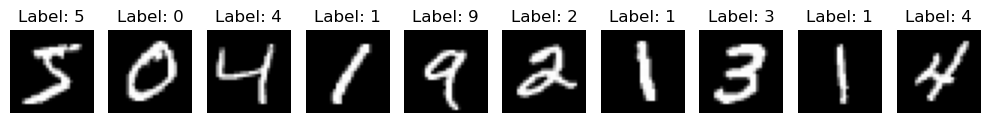

In [8]:
show_images(train_data)

Нормализуем данные, разделим на обучающую, валидационную и тестовую выборки

In [9]:
X_train = train_data.drop("label", axis = 1).values / 255
y_train = train_data["label"].values 

In [10]:
X_valid_test = test_data.drop("label", axis = 1).values / 255
y_valid_test = test_data["label"].values

In [11]:
y_valid_test = np.eye(10)[y_valid_test]
y_train = np.eye(10)[y_train]

In [12]:
X_valid, X_test, y_valid, y_test = train_test_split(X_valid_test, y_valid_test, random_state=42, test_size=0.5)

## Реализация класса многослойный персептрон

In [13]:
class MultilayerPerceptron:
    def __init__(self, input_size, output_size, hidden_layers, learning_rate, activation_function):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_layers = hidden_layers
        self.learning_rate = learning_rate
        
        if activation_function == 'sigmoid':
            self.activation_function = self.sigmoid
            self.activation_derivative = self.sigmoid_derivative
        elif activation_function == 'relu':
            self.activation_function = self.relu
            self.activation_derivative = self.relu_derivative
        elif activation_function == 'tanh':
            self.activation_function = self.tanh
            self.activation_derivative = self.tanh_derivative

        self.weights = []
        self.biases = []
                    
        self.layers_sizes = [input_size] + hidden_layers + [output_size]
  
        np.random.seed(42)
        for i in range(len(self.layers_sizes) - 1):
            stddev = np.sqrt(2 / self.layers_sizes[i])
            self.weights.append(np.random.randn(self.layers_sizes[i], self.layers_sizes[i+1]) * stddev)
            self.biases.append(np.zeros(self.layers_sizes[i+1]))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def relu(self, x):
        return np.maximum(0, x)

    def tanh(self, x):
        return np.tanh(x)

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def relu_derivative(self, x):
        return 1. * (x > 0)
    
    def tanh_derivative(self, x):
        return 1 - np.tanh(x)**2  
    
    def save(self, filepath):
        with open(filepath, "wb") as f:
            pickle.dump(self, f)
            
    @classmethod
    def load(cls, filepath):
        with open(filepath, "rb") as f:
            return pickle.load(f)
     
    def predict(self, inputs):
        for layer in range(len(self.layers_sizes) - 1):
            inputs = np.dot(inputs, self.weights[layer]) + self.biases[layer]
            inputs = self.activation_function(inputs)
        return inputs
    
    def train_on_batch(self, inputs, targets):
        activations = [inputs]
        for layer in range(len(self.layers_sizes) - 1):
            activations.append(self.activation_function(np.dot(activations[-1], self.weights[layer]) + self.biases[layer]))
        errors = []
        for i in range(len(activations) - 1, -1, -1):
            if i == len(activations) - 1:
                errors.append(activations[i] - targets)
            else:
                act_before_derivative = np.dot(errors[-1], self.weights[i].T)
                derivative_result = self.activation_derivative(activations[i])
                errors.append(act_before_derivative * derivative_result)

        for layer in range(len(self.layers_sizes) - 2, -1, -1):
            self.weights[layer] -= self.learning_rate * np.dot(activations[layer].T, errors[len(activations) - layer - 2])
            self.biases[layer] -= self.learning_rate * np.sum(errors[len(activations) - layer - 2], axis=0)

    def train(self, X, y, batch_size, epochs):
        for e in range(epochs):
            for i in range(0, len(X), batch_size):
                X_batch = X[i:i+batch_size]
                y_batch = y[i:i+batch_size]
                self.train_on_batch(X_batch, y_batch)


In [14]:
mlp = MultilayerPerceptron(
    input_size = 784,
    output_size = 10,
    hidden_layers = [128, 128, 512],
    learning_rate = 0.001,
    activation_function = 'sigmoid'
)
mlp.train(X_train, y_train, batch_size=128, epochs=10)
mlp.predict(X_test)
mlp.save('idk.pkl')

In [15]:
def compute_accuracy(model, X_test, y_test):
    y_pred = np.argmax(model.predict(X_test), axis=1)
    accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    return accuracy

In [16]:
idk_mpl = MultilayerPerceptron.load('idk.pkl')
accuracy = compute_accuracy(idk_mpl, X_test, y_test)
accuracy

0.935

Подбор топологии сети для получения наилучшего предсказания

In [17]:
%%time
best_accuracy = 0
best_parameters = None

for hidden_layer_sizes in [[64, 128], [128, 256, 256]]:
    for learning_rate in [0.0001, 0.001]:
        for activation_function in ['sigmoid', 'relu', 'tanh']:
            mlp = MultilayerPerceptron(input_size=784, hidden_layers=hidden_layer_sizes, output_size=10, 
                                        learning_rate=learning_rate, activation_function=activation_function)
            mlp.train(X_train, y_train, batch_size=128, epochs=10)
            y_pred = np.argmax(mlp.predict(X_valid), axis=1)
            accuracy = accuracy_score(np.argmax(y_valid, axis=1), y_pred)
            print(f"Parameters: hidden_layers={hidden_layer_sizes}, learning_rate={learning_rate}, activation_function={activation_function}, Accuracy={accuracy}")
            if accuracy > best_accuracy:
                mlp.save('best_mlp.pkl')
                best_accuracy = accuracy
                best_parameters = (hidden_layer_sizes, learning_rate, activation_function)

print(f"Best parameters: hidden_layers={best_parameters[0]}, learning_rate={best_parameters[1]}, activation_function={best_parameters[2]}, Accuracy={best_accuracy}")


Parameters: hidden_layers=[64, 128], learning_rate=0.0001, activation_function=sigmoid, Accuracy=0.839
Parameters: hidden_layers=[64, 128], learning_rate=0.0001, activation_function=relu, Accuracy=0.9398
Parameters: hidden_layers=[64, 128], learning_rate=0.0001, activation_function=tanh, Accuracy=0.92
Parameters: hidden_layers=[64, 128], learning_rate=0.001, activation_function=sigmoid, Accuracy=0.9426
Parameters: hidden_layers=[64, 128], learning_rate=0.001, activation_function=relu, Accuracy=0.9712
Parameters: hidden_layers=[64, 128], learning_rate=0.001, activation_function=tanh, Accuracy=0.9452
Parameters: hidden_layers=[128, 256, 256], learning_rate=0.0001, activation_function=sigmoid, Accuracy=0.6428
Parameters: hidden_layers=[128, 256, 256], learning_rate=0.0001, activation_function=relu, Accuracy=0.9518
Parameters: hidden_layers=[128, 256, 256], learning_rate=0.0001, activation_function=tanh, Accuracy=0.932
Parameters: hidden_layers=[128, 256, 256], learning_rate=0.001, activat

Проверим точность на тестовой выборке

In [18]:
best_mpl = MultilayerPerceptron.load('best_mlp.pkl')

In [19]:
accuracy = compute_accuracy(best_mpl, X_test, y_test)
accuracy

0.9748

**Вывод:** На тестовом наборе данных точность: 0.9748. Лучшие параметры: функция активации - relu, слои - (128, 256, 256), скорость обучения 0.001

## Сравнение с MLP из keras

In [20]:
y_valid_orig = np.argmax(y_valid, axis=1)
y_train_orig = np.argmax(y_train, axis=1) 
y_test_orig = np.argmax(y_test, axis=1) 

In [21]:
model = Sequential()
model.add(Input(shape=(784,)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2)) 
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax')) 

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train_orig, epochs=10, batch_size=128, validation_data=(X_valid, y_valid_orig))

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7928 - loss: 0.6668 - val_accuracy: 0.9540 - val_loss: 0.1469
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9513 - loss: 0.1634 - val_accuracy: 0.9670 - val_loss: 0.1026
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9599 - loss: 0.1249 - val_accuracy: 0.9726 - val_loss: 0.0892
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9689 - loss: 0.1012 - val_accuracy: 0.9762 - val_loss: 0.0792
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9719 - loss: 0.0883 - val_accuracy: 0.9754 - val_loss: 0.0821
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9743 - loss: 0.0770 - val_accuracy: 0.9786 - val_loss: 0.0741
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9789 - loss: 0.0657 - val_accuracy: 0.9778 - val_loss: 0.0755
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9800 - loss: 0.0637 - val_accuracy: 0.

In [22]:
loss, accuracy = model.evaluate(X_test, y_test_orig)
print("Test Accuracy:", accuracy)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - accuracy: 0.9760 - loss: 0.0878
Test Accuracy: 0.9760000109672546


**Вывод:** Точность у mlp из keras немного лучше: 0.976

## Расширение набора данных

Нарисуем по 10 цифр на каждую, загрузим их и расширим набор с помощью смещений, поворотов, шумов. 

In [23]:
import cv2
import numpy as np
import os
import csv

def read_image(filename, label):
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    img = 1 - (img / 255.0)
    img = cv2.resize(img, (28, 28))
    img = np.array(img)
    img = img.flatten()
    return [label] + img.tolist()

def write_to_csv(filename, data):
    with open(filename, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(data)

main_folder = "D:\\std\\SEM8\\nn\\img"
header = ["label"] + [f"{i//28 + 1}x{i%28 + 1}" for i in range(28 * 28)]
data = []


def augment_image(img):
    img = img.reshape(28, 28)
    dx, dy = np.random.uniform(-2, 2, size=2)
    M = np.float32([[1, 0, dx], [0, 1, dy]]) 
    img = cv2.warpAffine(img, M, (28, 28))
    angle = np.random.uniform(-10, 10) 
    M = cv2.getRotationMatrix2D((14, 14), angle, 1)
    img = cv2.warpAffine(img, M, (28, 28))
    noise = np.random.rand(28, 28) * 0.1
    img = np.clip(img + noise, 0, 1)
    return img.flatten()

for root, _, files in os.walk(main_folder):
    for idx, filename in enumerate(files):
        if not filename.endswith(".png"):
            continue
        label = root.split(os.sep)[-1]
        img_data = read_image(os.path.join(root, filename), label)
        data.append(img_data)
        for _ in range(99):
            augmented_img_data = read_image(os.path.join(root, filename), label)
            augmented_img_data[1:] = augment_image(np.array(augmented_img_data[1:]))
            data.append(augmented_img_data)

data.insert(0, header)
write_to_csv("digits.csv", data)

In [24]:
df = pd.read_csv("digits.csv")
df

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,0.083838,0.013316,0.069316,0.024112,0.006670,0.042050,0.035432,0.018777,0.067988,...,0.010872,0.009552,0.030556,0.096303,0.002906,0.039108,0.000616,0.066658,0.016855,0.047244
2,0,0.096549,0.083391,0.047079,0.076889,0.018533,0.081312,0.054793,0.001180,0.038910,...,0.039763,0.012802,0.046188,0.081566,0.053833,0.061491,0.025805,0.090598,0.044771,0.009668
3,0,0.082028,0.016145,0.008805,0.010743,0.024191,0.040596,0.085898,0.055996,0.095418,...,0.041468,0.064047,0.031989,0.027332,0.010690,0.037059,0.099658,0.093173,0.025823,0.047188
4,0,0.055667,0.022616,0.033580,0.006362,0.077645,0.040798,0.070751,0.091601,0.064181,...,0.090027,0.081407,0.030252,0.014410,0.098190,0.031760,0.099275,0.059427,0.043773,0.053373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9,0.019772,0.088463,0.062301,0.003316,0.048905,0.060532,0.092578,0.018283,0.087362,...,0.021379,0.065215,0.004014,0.066509,0.000512,0.091434,0.098468,0.037042,0.058434,0.002610
9996,9,0.053127,0.067886,0.068334,0.036758,0.084265,0.094848,0.030689,0.142020,0.244437,...,0.079408,0.041675,0.041999,0.021892,0.007992,0.002079,0.082440,0.072241,0.066958,0.084957
9997,9,0.017514,0.055078,0.006303,0.071668,0.038568,0.029162,0.009027,0.095691,0.018760,...,0.013312,0.036119,0.058409,0.028189,0.076387,0.053276,0.072547,0.071472,0.007392,0.025383
9998,9,0.035595,0.032006,0.008954,0.087505,0.017964,0.065646,0.009899,0.065839,0.054052,...,0.005456,0.048718,0.049492,0.065190,0.033829,0.075233,0.038605,0.042006,0.014259,0.085961


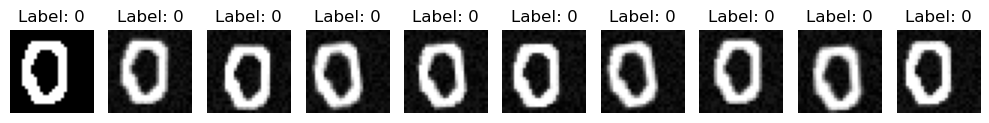

In [25]:
show_images(df)

In [26]:
df = df.sample(frac=1).reset_index(drop=True)
df.head(10)

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,3,0.065433,0.029744,0.059089,0.097392,0.030575,0.051652,0.031603,0.021272,0.005445,...,0.075625,0.040455,0.026606,0.049037,0.056679,0.031042,0.079063,0.000621,0.095742,0.070621
1,1,0.000500,0.032925,0.083751,0.082269,0.009272,0.000895,0.085008,0.070026,0.023108,...,0.029723,0.096500,0.095965,0.080493,0.083394,0.096550,0.020343,0.033311,0.007546,0.040028
2,4,0.025137,0.064843,0.093276,0.065816,0.068527,0.062488,0.027220,0.080092,0.034606,...,0.210516,0.060573,0.019535,0.081499,0.074697,0.089336,0.016842,0.053738,0.053348,0.027374
3,9,0.063192,0.061407,0.060489,0.073645,0.088797,0.077870,0.030526,0.078361,0.050035,...,0.091354,0.064523,0.079397,0.022711,0.089261,0.065630,0.086324,0.085097,0.092058,0.080251
4,3,0.000871,0.072266,0.084213,0.056975,0.003622,0.084530,0.064256,0.066470,0.039294,...,0.061499,0.079475,0.087051,0.024525,0.065358,0.011698,0.026108,0.077145,0.053454,0.001377
5,8,0.033197,0.071389,0.080405,0.033165,0.024887,0.050343,0.051040,0.091600,0.067019,...,0.005610,0.010276,0.044770,0.009965,0.047952,0.010355,0.076364,0.045141,0.002554,0.097502
6,3,0.059185,0.024192,0.036582,0.031469,0.089617,0.072494,0.064346,0.018888,0.006539,...,0.002697,0.089115,0.052301,0.016653,0.028170,0.035442,0.051749,0.030629,0.028176,0.001583
7,1,0.081164,0.091549,0.016339,0.097697,0.077901,0.003039,0.031297,0.077669,0.002004,...,0.073381,0.030837,0.027033,0.046127,0.009193,0.028441,0.006906,0.088822,0.028241,0.031643
8,1,0.059263,0.060757,0.065732,0.049772,0.074266,0.084698,0.047223,0.021558,0.031033,...,0.064036,0.088002,0.097735,0.085178,0.045622,0.096836,0.099618,0.006807,0.071164,0.053532
9,5,0.017241,0.053717,0.004923,0.092789,0.099679,0.000520,0.081509,0.078196,0.079277,...,0.077691,0.024434,0.066656,0.013711,0.045047,0.055554,0.012861,0.049285,0.080333,0.008837


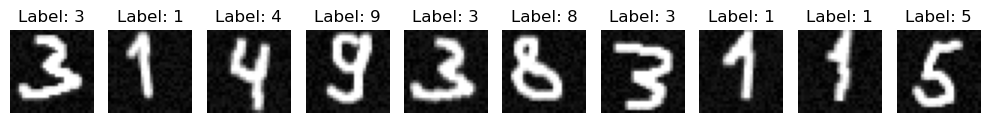

In [27]:
show_images(df)

In [28]:
X_new = df.drop('label', axis=1).values 
y_new_orig = df['label'].values 
y_new = np.eye(10)[y_new_orig]

In [29]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, random_state=42, test_size=0.3)

In [30]:
y_train_new_orig = np.argmax(y_train_new, axis=1) 
y_test_new_orig = np.argmax(y_test_new, axis=1) 

In [31]:
loss, accuracy = model.evaluate(X_test_new, y_test_new_orig)
print("Точность keras на новых данных:", accuracy)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - accuracy: 0.4350 - loss: 4.4809
Точность keras на новых данных: 0.4399999976158142


In [32]:
accuracy = compute_accuracy(best_mpl, X_test_new, y_test_new)
print("Точность своей mlp на новых данных:", accuracy)

Точность своей mlp на новых данных: 0.49133333333333334


Дообучим модель на новых данных

In [33]:
best_mpl.train(X_train_new, y_train_new, batch_size=128, epochs=10)

Объединим данные с данными из mnist

In [34]:
X_test_full = np.concatenate((X_test, X_test_new), axis=0)

In [35]:
y_test_full = np.concatenate((y_test, y_test_new), axis=0)

In [36]:
accuracy = compute_accuracy(best_mpl, X_test_full, y_test_full)
print("Точность своей mlp на объединенных данных:", accuracy)

Точность своей mlp на объединенных данных: 0.88825
